In [1]:
# Comment out the line below and install Dynamic Time Warping, tslearn and Soft DTW
# !pip install dtw-python

# !pip install tslearn

# Install soft-dtw using the following commands on the commanldine
# cd soft-dtw-master
# make cython
# python setup.py build
# sudo python setup.py install

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import music21
import dtw
import sdtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Part A: Timing function

### Read annotations

In [3]:
def read_anno(file_path):
    with open(file_path, 'r') as file:
        # read the raw txt and parse the columns
        lines = [[col for col in row.replace('\n','').split('\t')] for row in file.readlines()]
        #parse the last col of the first row
        # print(lines[0], lines[1])
        lines[0][-1], time_sign, key_sign = lines[0][-1].split(',')
        # print(time_sign, key_sign, lines[0], lines[1])
        #separate columns
        times1 = np.array([float(row[0]) for row in lines])
        times2 = np.array([float(row[1]) for row in lines])
        beats = np.array([1 if row[2] == 'db' else 0 for row in lines])
        # print(times1, beats)
        return times1, beats, time_sign, key_sign

### Linear estimator for model parameters

In [4]:
def compute_w(x, y, add_bias):
    # outputs a mapping between performed and unperformed files
    # w * x + eps = y # eps ~ N(0,sigma)
    # minimize_w w^2 * x^2 - 2 w * x.T @ y + y^2
    # 2 w x^2 - 2 y.T x = 0
    # w = pinv(x.T x) x.T y # pinv ~ pseudo inverse
    if add_bias:
        x = np.concatenate((x, np.ones((x.shape[0],1))), axis=1)
    w = np.linalg.pinv(x.T @ x) @ x.T @ y
    return w

def compute_y_(x, w, add_bias):
    # outputs pseudo-performed times from unperformed times
    if add_bias:
        x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    y_ = x @ w
    return y_

def compute_y_scalar(t, w):
    t_scaled = t * w[0] + w[1]
    return t_scaled

### Linear estimator for noise parameters

In [5]:
def compute_eps(x, y, add_bias=True):
    if x.ndim == 1:
        x = x[:,None]
        y = y[:,None]
    w = compute_w(x, y, add_bias)
    y_ = compute_y_(x, w, add_bias)
    eps = y - y_
    mu, sigma = eps.mean(), eps.std()
    return w, mu, sigma, eps

### Linear generator

In [6]:
def generate(x, w, mu, sigma, add_bias=True, noisy=False):
    if x.ndim == 1:
        x = x[:,None]
    y_ = compute_y_(x, w, add_bias)
    eps = np.random.normal(mu, sigma, x.shape[0])
    y_gen = y_ + int(noisy) * eps
    return y_gen

In [7]:
def timing(x, y, add_bias=True, noisy=False):
    w, mu, sigma, err = compute_eps(x,y)
    y_gen = generate(x, w, mu, sigma, add_bias=add_bias, noisy=noisy)
    return y_gen

### Read the annotations and generate pseudo-performed times based on a performed-unperformed pair

In [8]:
unperformed_path = "Data/Bach/Prelude/bwv_875/midi_score_annotations.txt"
performer_paths = [
    ("Data/Bach/Prelude/bwv_875/Ahfat01M_annotations.txt"),
    ("Data/Bach/Prelude/bwv_875/CaoJ01M_annotations.txt"),
    ("Data/Bach/Prelude/bwv_875/Hong04M_annotations.txt")
]

unperformed_annotation = read_anno(unperformed_path)[0]
performed_annotations = [read_anno(path)[0] for path in performer_paths]
performed_annotation = performed_annotations[-1]# Hong04M

performed2unperformed = {perf: unperf for perf, unperf in zip(performed_annotation, unperformed_annotation)}
unperformed2performed = {unperf: perf for unperf, perf in zip(unperformed_annotation, performed_annotation)}
w, mu, sigma, err = compute_eps(unperformed_annotation, performed_annotation)
pseudo_performed = generate(unperformed_annotation, w, mu, sigma)

### Plot the offsets and errors

/Users/ozaydin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


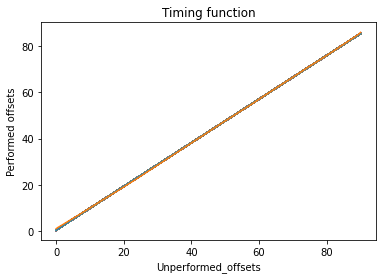

In [9]:
fig, ax = plt.subplots()
ax.plot(unperformed_annotation, pseudo_performed)
ax.plot(unperformed_annotation, performed_annotation)
ax.set_title('Timing function')
ax.set_ylabel('Performed offsets')
ax.set_xlabel('Unperformed_offsets')
fig.show()

/Users/ozaydin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


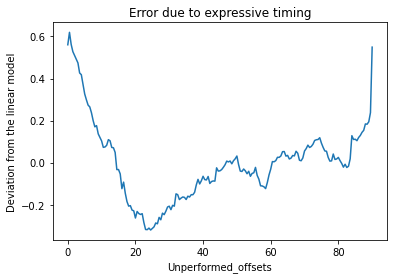

In [10]:
fig, ax = plt.subplots()
ax.plot(unperformed_annotation, err)
# ax.plot(unperformed_annotations, beats)
ax.set_title('Error due to expressive timing')
ax.set_ylabel('Deviation from the linear model')
ax.set_xlabel('Unperformed_offsets')
fig.show()

## Part B: MIDI features

### Compute note features based on the MIDI file

In [11]:
def read_midi(path):
    # music21.midi.MidiFile.read(path)
    # return helpers_simplify_score_for_rhythm_analysis(music21.converter.parse(path))
    return music21.converter.parse(path)
    
def compute_midi_features(midi, referent=1.0, number=120.0):
    n_measures = len(midi.getElementsByClass('Part')[0].getElementsByClass('Measure'))
    len_midi = midi.duration.quarterLength
    mm1 = music21.tempo.MetronomeMark(referent=referent, number=number) # Manually set. Cannot automate, bpm seems to be 171 in midi but 120 is more accurate.
    
    piece = {}
    times = []
    all_feats = []
    all_times = []
    part_no = -1
    for part in midi.parts:
        part_no += 1
        for measure in part.getElementsByClass('Measure'):
            for event in measure.recurse().getElementsByClass('Note'):
                event_offset_score = mm1.durationToSeconds(event.getOffsetInHierarchy(midi))
                event_offset_measure = event.getOffsetInHierarchy(measure)
                measure_offset = measure.getOffsetInHierarchy(midi) / len_midi
                measure_offset_neg = 1 - measure_offset
                event_duration = mm1.durationToSeconds(event.duration)
                event_pitch = event.pitch.midi
                event_volume = event.volume.velocity
                event_interval_next = music21.interval.Interval(event, event.next('Note'))
                event_interval_prev = music21.interval.Interval(event.previous('Note'), event)
                event_part = part_no
                
                feat = np.array([event_offset_score,
                                 event_offset_measure,
                                 measure_offset,
                                 measure_offset_neg,
                                 event_duration,
                                 event_pitch,
                                 event_volume,
                                 event_interval_next.generic.directed\
                                     if event_interval_next.generic is not None else 0,
                                 event_interval_prev.generic.directed\
                                     if event_interval_prev.generic is not None else 0,
                                 event_part])
                
                if event_offset_score not in piece.keys():
                    piece[event_offset_score] = [feat]
                    times.append(event_offset_score)
                else:
                    piece[event_offset_score].append(feat)
                
                all_feats.append(feat)
                all_times.append(feat[0])
                
    times_set = sorted(set(times))
    feats_array = np.stack(all_feats, axis=0)
    times_array = np.stack(all_times, axis=0)
    return times_set, piece, times_array, feats_array

In [12]:
unperformed_midi = read_midi(unperformed_path.replace('_annotations.txt', '.mid'))
performed_midis = [read_midi(path.replace('_annotations.txt', '.mid')) for path in performer_paths]
performed_midi = performed_midis[-1] #Hong04M

unperformed_times, unperformed_feat, unp_times, unp_feats = compute_midi_features(unperformed_midi)
performed_times, performed_feat, p_times, p_feats = compute_midi_features(performed_midi)
scaled_unperformed_times = [compute_y_scalar(t, w) for t in unperformed_times]

pseudo_performed_times = [t + np.random.normal(mu, sigma) for t in scaled_unperformed_times]

print(len(unperformed_times), len(performed_times), max(unperformed_times), max(performed_times))
print(unperformed_times)
print(performed_times)
print(unp_times.shape, unp_feats.shape, p_times.shape, p_feats.shape)

717 138 89.875 85.75
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2.0, 2.125, 2.25, 2.375, 2.5, 2.625, 2.75, 2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.625, 3.75, 3.875, 4.0, 4.125, 4.25, 4.375, 4.5, 4.625, 4.75, 4.875, 5.0, 5.125, 5.25, 5.375, 5.5, 5.625, 5.75, 5.875, 6.0, 6.125, 6.25, 6.375, 6.5, 6.625, 6.75, 6.875, 7.0, 7.125, 7.25, 7.375, 7.5, 7.625, 7.75, 7.875, 8.0, 8.125, 8.25, 8.375, 8.5, 8.625, 8.75, 8.875, 9.0, 9.125, 9.25, 9.375, 9.5, 9.625, 9.75, 9.875, 10.0, 10.125, 10.25, 10.375, 10.5, 10.625, 10.75, 10.875, 11.0, 11.125, 11.25, 11.375, 11.5, 11.625, 11.75, 11.875, 12.0, 12.125, 12.25, 12.375, 12.5, 12.625, 12.75, 12.875, 13.0, 13.125, 13.25, 13.375, 13.5, 13.625, 13.75, 13.875, 14.0, 14.125, 14.25, 14.375, 14.5, 14.625, 14.75, 14.875, 15.0, 15.125, 15.25, 15.375, 15.5, 15.625, 15.75, 15.875, 16.0, 16.125, 16.25, 16.375, 16.5, 16.625, 16.75, 16.875, 17.0, 17.125, 17.25, 17.375, 17.5, 17.625, 17.75, 17.875, 18.0, 18.125, 

### Dynamic Time Warping, only based on time

/Users/ozaydin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


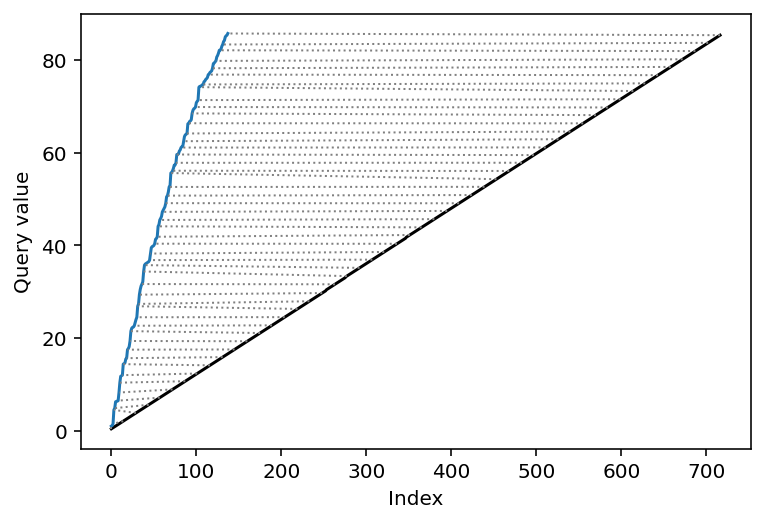

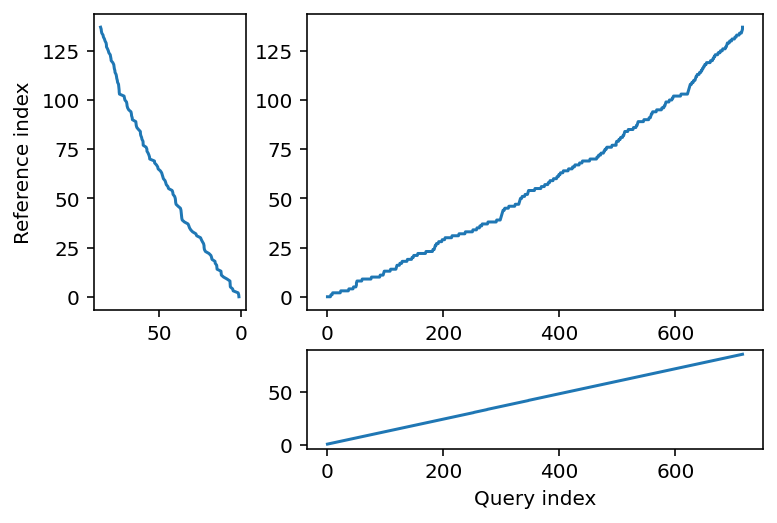

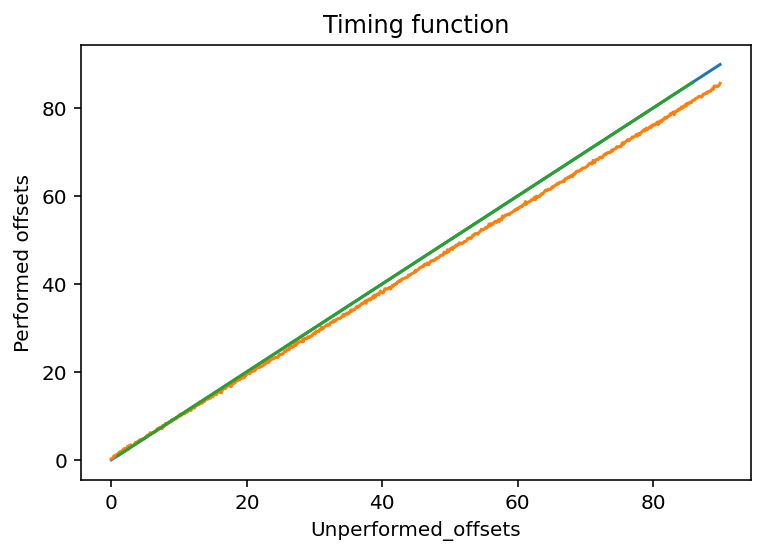

In [13]:
alignment = dtw.dtw(scaled_unperformed_times, performed_times, keep_internals=True)
alignment.plot(type="twoway")
alignment.plot(type="threeway")
# print(alignment, scaled_unperformed_times)

fig, ax = plt.subplots()
# ax.plot(unperformed_times, scaled_unperformed_times)
ax.plot(unperformed_times, pseudo_performed_times)
ax.set_title('Timing function')
ax.set_ylabel('Performed offsets')
ax.set_xlabel('Unperformed_offsets')
fig.show()

### Soft Dynamic Time Warping, based on time and midi features

In [14]:
import sdtw.distance
D = sdtw.distance.SquaredEuclidean(unp_feats, p_feats)
warper = sdtw.SoftDTW(D, gamma=1.0)